# Binaryzacja

### Zadanie domowe - binaryzacja adaptacyjna w oknach z interpolacją.

Pokazana w ramach podstawowej części ćwiczenia binaryzacja adaptacyjna działa dobrze, ale jest dość złożona obliczeniowo (choć oczywiście należy mieć świadomość, że implementację można zoptymalizować i wyeliminować pewne powtarzające się obliczenia).
Zbliżone rozwiązanie można również realizować w nieco innym wariancie - w oknach.
Ogólna idea jest następująca: wejściowy obraz dzielimy na nienachodzące (rozłączne) okna - wygodnie jest założyć, że są one kwadratowe i o rozmiarze będącym potęgą liczby 2.
W każdym z okien obliczamy próg - niech to będzie średnia i stosujemy do binaryzacji lokalnej.
Jak nietrudno się domyślić efekt nie będzie dobry, gdyż na granicach okien wystąpią artefakty.
Aby je wyeliminować należy zastosować interpolację, co zostanie szczegółowo opisane poniżej.
Warto zaznaczyć, że podobny mechanizm interpolacji stosowany jest w poznanym wcześniej algorytmie CLAHE.
Zainteresowane osoby odsyłam do artykułu na [Wikipedii](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) oraz do artykułu o metodzie CLAHE - Zuiderveld, Karel. “Contrast Limited Adaptive Histograph Equalization.” Graphic Gems IV. San Diego: Academic Press Professional, 1994. 474–485.



Na początek zaimplementujemy wariant metody bez interpolacji:
1. Wczytaj obraz _rice.png_.
2. W dwóch pętlach `for`, dla okien o ustalonym wymiarze $W$ (potęga 2), oblicz średnią:
- pętle powinny mieć krok $W$,
- wynik (tj. średnie) należy zapisać w pomocniczej tablicy,
- przydatny operator to `//` - dzielenie całkowitoliczbowe (*floor division*).

3. W kolejnych dwóch pętlach `for` (tym razem o kroku 1) przeprowadź binaryzację z wyznaczonymi progami.
   Tu oczywiście należy się sprytnie odwołać do wyników z tablicy pomocniczej.
   Wyświetl wyniki - czy jest on poprawny?
   Podpowiedź - błędy lepiej widać dla mniejszego rozmiaru okna (np. 16 x 16).

In [3]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/04_Thresholding/'

fileName = "rice.png"
if not os.path.exists(fileName):
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

In [4]:
def read_img(image_name):
    img = cv2.imread(image_name)
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def show_img(img:np.ndarray[int], title:str=None):
    plt.imshow(img, cmap='gray')
    plt.title(f'{title if title else ""} ')
    plt.rcParams['figure.figsize'] =(7, 7)
    plt.show()
    
def show_hist(img_hist:np.ndarray[int], title:str=None):
    plt.xticks(np.arange(0, 256, 20.0))
    plt.rcParams['figure.figsize'] =(10, 5)
    plt.grid()
    plt.title(f'{title if title else ""}')
    plt.plot(img_hist)
    plt.show()
    

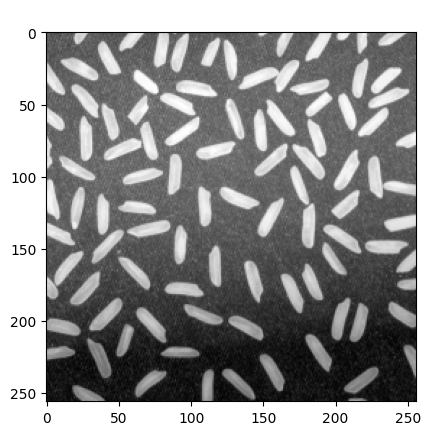

C:\Users\Dominik\AppData\Local\Temp\ipykernel_22700\713309822.py:12: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  binarized[i, j] = [0, 255][img[i, j] > means[i // W, j // W]]


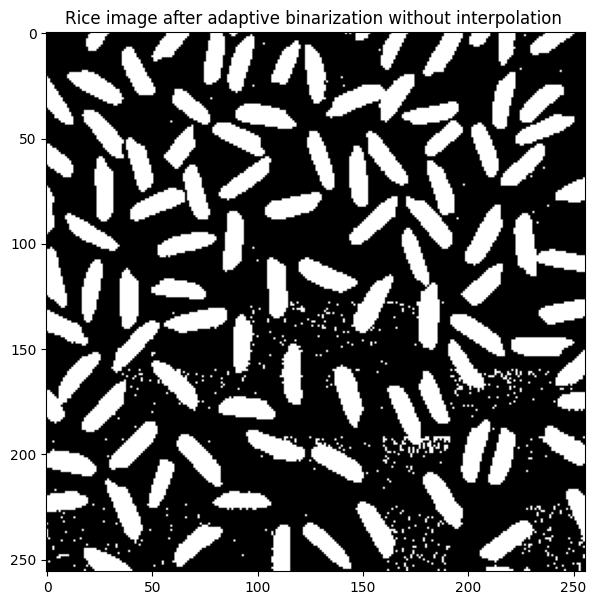

In [5]:

def window_means(img, W=16):
    means = np.zeros((img.shape[0] // W, img.shape[1] // W))
    for i in range(0, img.shape[0], W):
        for j in range(0, img.shape[1], W):
            means[i // W, j // W] = np.mean(img[i:i+W, j:j+W])
    return means
def adaptive_binarization_without_interpolation(img, W):
    means = window_means(img, W)
    binarized = np.copy(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            binarized[i, j] = [0, 255][img[i, j] > means[i // W, j // W]]
    return binarized

rice_img = read_img('rice.png')
show_img(rice_img)
show_img(adaptive_binarization_without_interpolation(rice_img, 32), title='Rice image after adaptive binarization without interpolation')

4. Rozwiązaniem problemu artefaktów na obrazie jest zastosowanie interpolacji.
   Próg binaryzacji dla danego piksela wyliczany jest na podstawie progów z sąsiednich okien.
   ![Ilustracja koncepcji interpolacji](https://raw.githubusercontent.com/vision-agh/poc_sw/master/04_Thresholding/clahe_tile_interpolation.png)

   Koncepcja została przedstawiona na powyższym rysunku.
   Możliwe są 3 przypadki:
   - piksel leży w rogach obrazu (kolor czerwony) - wtedy za próg przyjmuje się wartość średniej obliczonej dla danego okna,
   - piksel leży na krawędzi obrazu (kolor zielony) - wtedy za próg przyjmuje się wartość obliczoną na podstawie średnich z dwóch sąsiednich okien,
   - piksel leży w środku (kolor fioletowy) - wtedy próg jest obliczany na podstawie 4 sąsiednich okien.

   Uwaga. Proszę zwrócić uwagę, że sprawa jest dość złożona.
   Obraz dzielimy na okna (dla nich liczymy średnią) i następnie każde z okien "wirtualnie" na cztery sub-okna (linie przerywane).
   To ułatwia znalezienie środków okien (czarne kwadraty), które są wykorzystywane w interpolacji.

5. Implementujemy interpolację.
   Potrzebujemy do tego znać progi (jeden, dwa lub cztery), ale dla przejrzystości obliczeń lepiej zawsze przyjąć cztery oraz odległości od rozważnego piksela do środka sąsiednich okien (też w ogólnym przypadku 4):
   - całość sprowadza się do określania pozycji piksela,
   - na początek rozważmy przypadek czterech narożników (kolor czerwony na rysunku) - trzeba napisać `if`, który je wyznaczy,
   - warto sprawdzić, czy nie popełniliśmy błędu i np. tymczasowo do obrazu wynikowego w tym miejscu przypisać wartość 255. Efekt powinien być taki, że widoczne będą tylko narożniki.
   - drugi przypadek do brzegi (kolor zielony) - postępujemy podobnie jak przy narożnikach, przy czym osobno wydzielamy brzegi pionowe i poziome. Tu też warto sobie obrazek "pokolorować".
   - na koniec wyznaczamy piksele w środku.
   - analizując poprawność proszę zwrócić uwagę na to, żeby nie było przerw pomiędzy obszarami.
   - mając podział możemy dla każdego z obszarów wyliczyć cztery progi ($t11, t12, t21, t22$):
        - dla narożników wartość ta będzie identyczna i wynosi po prostu `t11 =t[jT][iT]`, gdzie `iT=i//W` oraz `jT=j//W`.
          Uwaga. Proszę używać indeksów tymczasowych $jT,iT$, gdyż będą potrzebne w dalszych obliczeniach.
        - dla brzegów pionowych występują dwie wartości: okno bieżące i sąsiednie.
          Wyznaczenie współrzędnej poziomej jest proste (jak dla narożników).
          Nad współrzędną pionową trzeba się chwilę zastanowić - aby nie rozważać wielu przypadków można od bieżącej współrzędnej odjąć połowę rozmiaru okna i dopiero później wykonać dzielenie przez rozmiar okna.
          W ten sposób otrzymujemy indeks okna o mniejszej współrzędnej.
          Indeks drugiego uzyskamy dodając 1.
          Proszę się zastanowić dlaczego to działa - najlepiej to sobie rozrysować.
        - dla brzegów poziomych należy postąpić analogicznie,
        - obliczenia dla obszaru wewnątrz powinny być już oczywiste.
   - kolejny krok to wyliczenie odległości pomiędzy rozważanym pikselem, a czterema środkami.
     Przykładowo dla osi X wygląda to następująco: `dX1 = i - W/2 - iT*W` oraz `dX2 = (iT+1)*W - i-W/2`.
     Dla osi Y analogicznie.
     Ponownie proszę się zastanowić dlaczego to jest poprawne - najlepiej to sobie narysować.
   - ostatni krok to interpolacja dwuliniowa.
     Wykonamy ją w trzech krokach:
     - interpolacja w osi X dla dwóch górnych okien - sprowadza się ona do średniej ważonej pomiędzy wartościami $t11$ i $t12$, przy czym wagi to odpowiednio $dX2/W$ i $dX1/W$.
       Ponownie na podstawie rysunku proszę to przemyśleć.
     - interpolacja w osi X dla dolnych okien jest analogiczna,
     - interpolacja w osi Y również jest analogiczna, z tym, że wejściem są dwa wyniki interpolacji w poziomie.

6. "Kropka nad i" to oczywiście binaryzacja z wyznaczonym poprzez interpolację progiem - proszę dobrać rozmiar okna.
7. Na koniec proszę porównać na wspólnym rysunku poznane metody binaryzacji:
- Otsu,
- lokalna na podstawie średniej,
- lokalna Sauvoli,
- lokalna w oknach bez interpolacji,
- lokalna w oknach z interpolacją.

Proszę pod porównaniem, w osobnej sekcji *markdown*, krótko skomentować uzyskane wyniki.

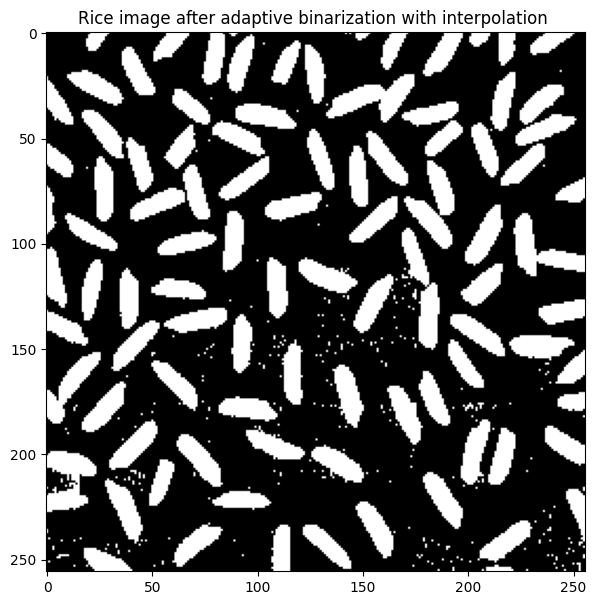

In [8]:

                
def in_corners(width:int, height:int, i:int, j:int) -> bool:
    return i in [0, width-1] and j in [0, height-1]


def in_horizontal_edges(width:int, height:int, i:int, j:int) -> bool:
    return i in [0, width-1] and 1 <= j <= height-2


def in_vertical_edges(width:int, height:int, i:int, j:int) -> bool:
    return j in [0, height-1] and 1 <= i <= width-2


def adaptive_binarization_with_interpolation(img, window_size):

    def interpolate(x1, x2, w1, w2):
        return (x1 * w1 + x2 * w2) / window_size

    width, height = img.shape
    w = window_size // 2
    means = window_means(img, W=window_size)

    binarized_img = img.copy()

    for i in range(width):
        for j in range(height):

            big_window_i =  i // window_size
            big_window_j = j  // window_size

            small_window_i = i // w
            small_window_j = j // w

            iT = (i-w) // window_size
            jT = (j-w) // window_size

            if in_corners(width //  w , height // w , small_window_i, small_window_j):
                t11 = t12 = t21 = t22 = means[big_window_i, big_window_j]

            elif in_horizontal_edges(width // w , height // w , small_window_i, small_window_j):


                t11 = t21 = means[big_window_i, jT]
                t12 = t22 = means[big_window_i, jT+1]

 
            elif in_vertical_edges(width // w , height // w , small_window_i, small_window_j):


                t11 = t12 = means[iT, big_window_j]
                t21 = t22 = means[iT+1, big_window_j]

            else:
               
                t11 = means[iT, jT]
                t12 = means[iT, jT + 1]
                t21 = means[iT + 1, jT]
                t22 = means[iT + 1, jT + 1]
                
                
            
            dX1 = i - iT * window_size - window_size // 2
            dX2 = window_size - dX1
            dY1 = j - jT * window_size - window_size // 2
            dY2 = window_size - dY1

            xt1 = interpolate(t11, t12, dX2, dX1)
            xt2 = interpolate(t21, t22, dX2, dX1)

            t = interpolate(xt1, xt2, dY2, dY1)


            binarized_img[i, j] = 255 if img[i, j] >= t else 0

    return binarized_img


show_img(adaptive_binarization_with_interpolation(rice_img, 32), title='Rice image after adaptive binarization with interpolation')







In [113]:
def local_binarization(img, window_size):
    w, h = img.shape
    wr = window_size //2
    bin_img = np.copy(img)
    for j in range(wr , h - wr):
        for i in range(wr, w - wr):
            bin_img[i, j] = [0, 255][img[i,j] > np.mean(img[i-wr:i+wr, j-wr:j+wr])]
    return  bin_img

In [141]:
def otsu_binarization(image):
    hist = np.squeeze(cv2.calcHist([image], [0], None, [256], [0, 256]) / image.size)

    mg = np.arange(0, 256) @ hist
    max_sigma_B = 0
    best_threshold = 0
    p_0 = 0
    bin_img = image.copy()
    for k in range(1,257):
        p_0 += hist[k-1]
        if not 0.0 < p_0 < 1.0:
            continue
            
        m_k = np.arange(0, k) @ hist[:k]
        
        sigma_B = ((mg*p_0-m_k)**2)/(p_0*(1-p_0))
        
        if sigma_B > max_sigma_B:
            max_sigma_B = sigma_B
            best_threshold = k
            
    return (bin_img > best_threshold-1).astype(np.uint8)        

In [142]:
def sauvoli_binarization(image,window_size, R = 128, k= 0.15, sign=1):
    
    w, h = image.shape
    wr = window_size // 2
    bin_img = np.copy(image)
    for j in range(wr, h - wr):
        for i in range(wr,w - wr):
            window = image[i-wr:i+wr, j-wr:j+wr]
            window_mean = np.mean(window)
            window_std = np.std(window)
            threshold = image[i, j] >  window_mean *(1 + sign*k * (window_std/R -1))
            bin_img[i, j] = [0, 255][threshold]
            
    return bin_img

In [143]:
def show_binarization_method_comparison(original_image, images_after_binarization: list[list[np.ndarray, str]]):
    n = len(images_after_binarization)
    
    fig, ax = plt.subplots(n, 2, figsize=(20, 10*n))
    
    for idx, val in enumerate(images_after_binarization):
        ax[idx, 0].imshow(original_image, cmap='gray')
        ax[idx, 0].set_title('Original image')
        ax[idx, 0].axis('off')
        ax[idx, 1].imshow(val[0], cmap='gray')
        ax[idx, 1].set_title(f'Image after {val[1]} ')
        ax[idx, 1].axis('off')
        
    plt.show()
        

C:\Users\Dominik\AppData\Local\Temp\ipykernel_19204\1488095411.py:7: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  bin_img[i, j] = [0, 255][img[i,j] > np.mean(img[i-wr:i+wr, j-wr:j+wr])]
C:\Users\Dominik\AppData\Local\Temp\ipykernel_19204\2852838257.py:12: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  bin_img[i, j] = [0, 255][threshold]


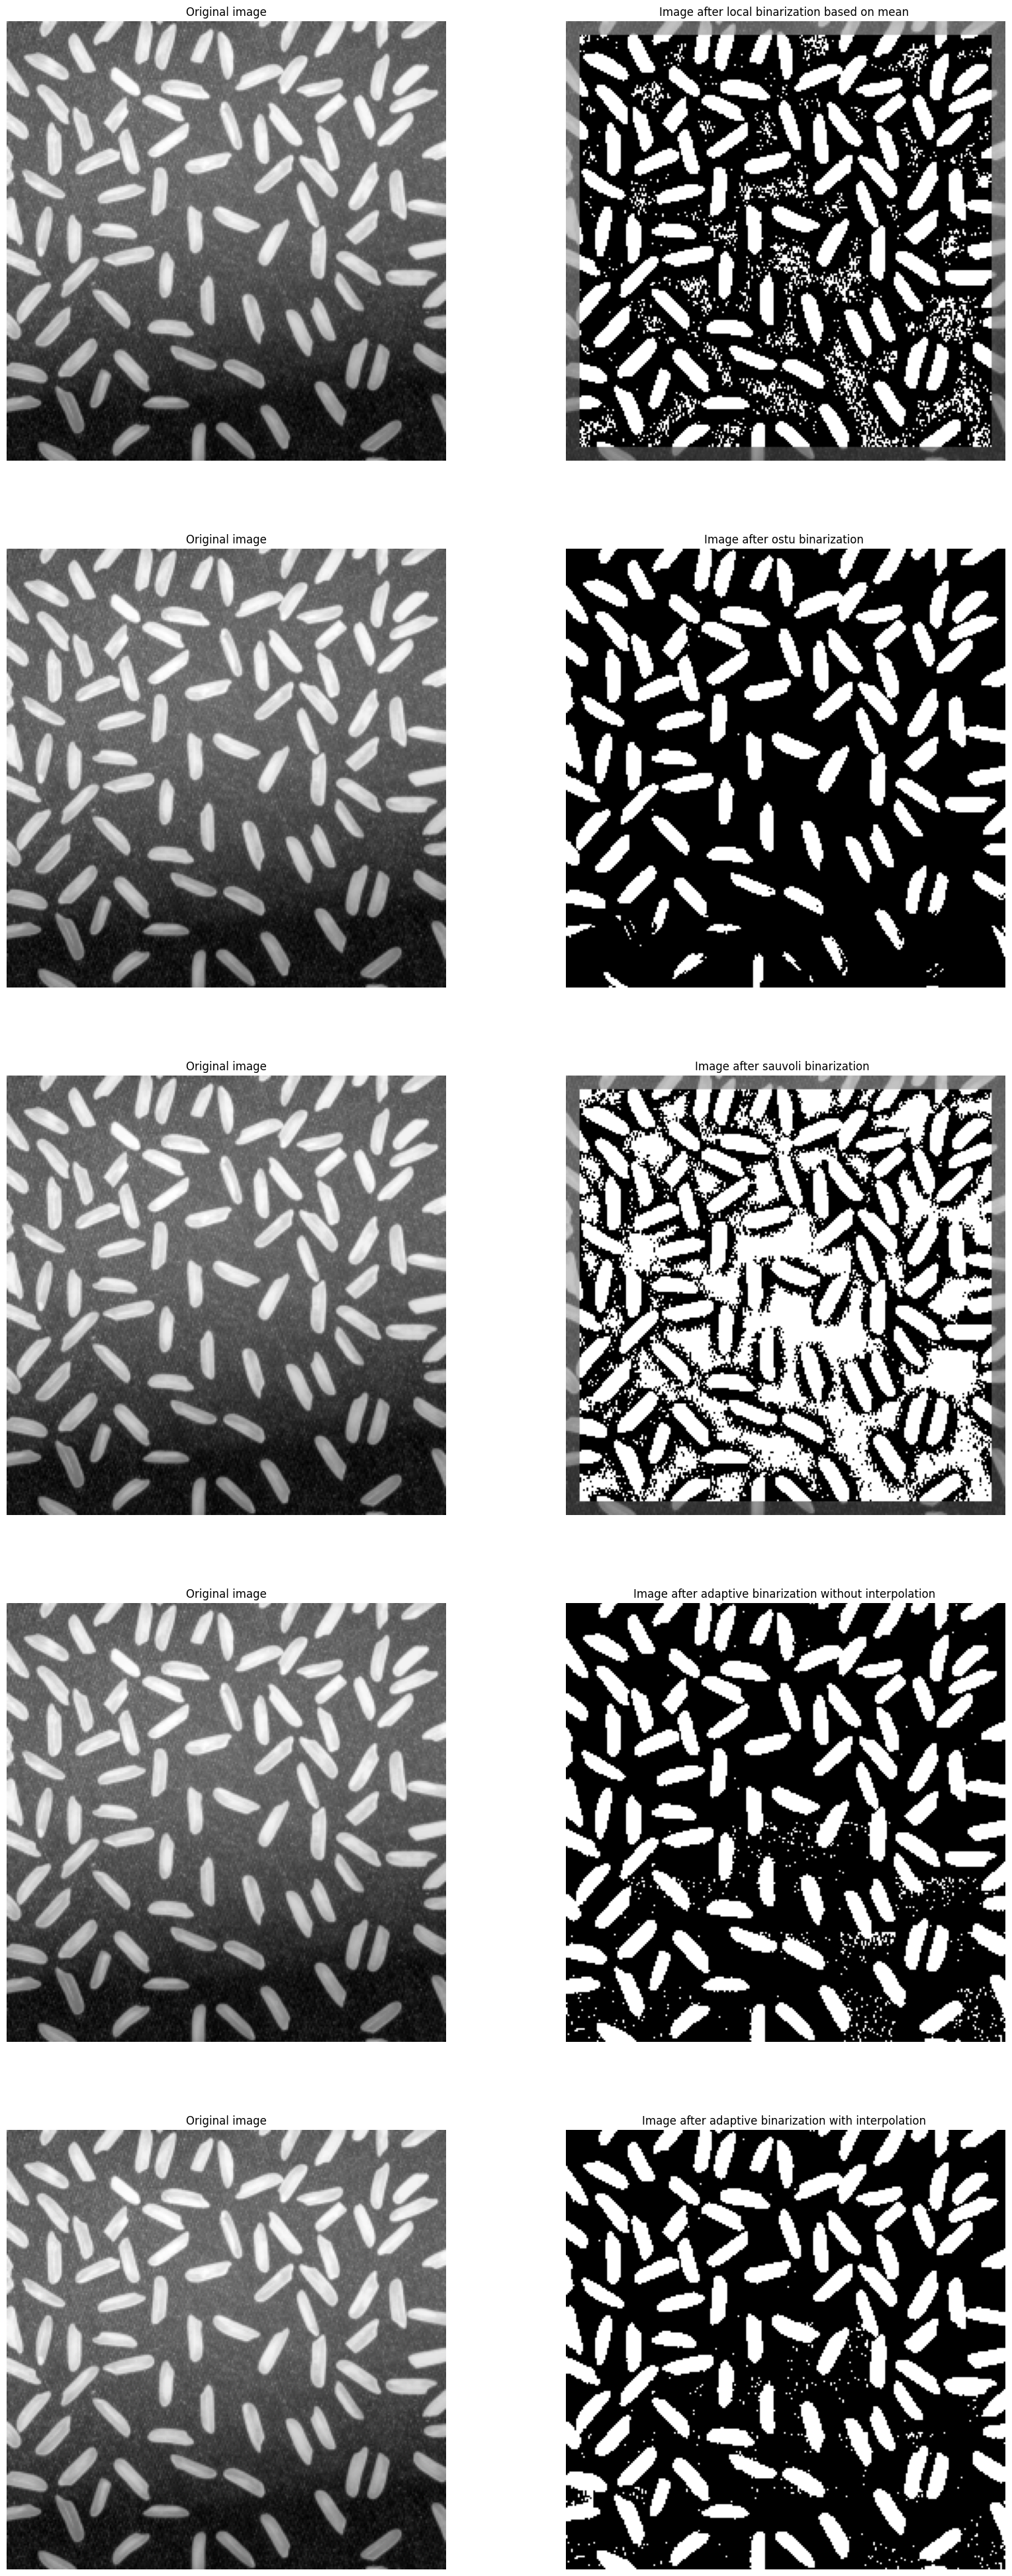

In [144]:
window_size = 32
rice_image = read_img('rice.png')
images_after_bin = [
    [local_binarization(rice_img, 16),'local binarization based on mean'],
    [otsu_binarization(rice_img),'ostu binarization'],
    [sauvoli_binarization(rice_img, 16),'sauvoli binarization '],
    [adaptive_binarization_without_interpolation(rice_img, window_size),'adaptive binarization without interpolation'],
    [adaptive_binarization_with_interpolation(rice_img, window_size),'adaptive binarization with interpolation']
]



show_binarization_method_comparison(rice_img,images_after_bin)